In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import mean_squared_error
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurveExtractor, merge_curves

import sys
sys.path.append("../../2022-ecml/analysis")
# from utils_fit import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database import fit_model#, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve

In [32]:
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

openmlid = 11    # 3,6,11,12,14
workflow = workflows[0]

# retrieve learning curve objects
lcdb = LCDB()
df = lcdb.query(
    openmlids=[openmlid],
    workflows=[workflow],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val"]
        )
    },
    show_progress=True
)

# group by configurations
config_cols = [c for c in df.columns if c.startswith("p:")]
df = df.groupby(config_cols).agg({"learning_curve": merge_curves})

100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


In [33]:
max_schedule = df["learning_curve"].iloc[0].anchors_size
print(max_schedule)

[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 500]


In [34]:
df["learning_curve"].apply(lambda x: x.pad_anchors_size(max_schedule, inplace=True))

p:metric       p:n_neighbors  p:pp@cat_encoder  p:pp@decomposition  p:pp@featuregen  p:pp@featureselector  p:pp@scaler  p:weights  p:p  p:pp@kernel_pca_kernel  p:pp@kernel_pca_n_components  p:pp@poly_degree  p:pp@selectp_percentile  p:pp@std_with_std
cosine         1              onehot            agglomerator        none             none                  minmax       uniform    1    linear                  0.250000                      2                 25                       True                 <lcdb.analysis.util.LearningCurve object at 0x...
                                                                                     selectp               none         distance   1    linear                  0.250000                      2                 90                       True                 <lcdb.analysis.util.LearningCurve object at 0x...
                                                                    poly             selectp               std          distance   1    linea

## Parametric model fitting

In [35]:
model_group = ['last1', 'pow4', 'mmf4', 'wbl4', 'exp4']

In [36]:
def curves_models_fitting(lc_data, model_names, extrapolate, input_mask, rep=20, verbose=True):
    fitting_results = []

    # counters for successful fits
    model_fit_stats = {model_name: {"successful_fits": 0, "total_fits": 0} for model_name in model_names}

    pbar = tqdm(total=len(lc_data) * len(model_names), smoothing=0, miniters=1)
    for lc in lc_data:
        schedule = lc.anchors_size  
        
        # ensure no NaN values in lc
        if np.any(~np.isnan(lc.values)):
            # compute mean
            lc = lc.values[0, 1, :, :, :, :, -1] if lc.is_iteration_wise_curve else lc.values[0, 1]
            scores = np.nanmean(lc, axis=(0, 1, 2)).squeeze() 
            
            for model_name in model_names:
                model_fit_stats[model_name]["total_fits"] += 1  

                try:    # fitting
                    if extrapolate: 
                        train_schedule = np.array(schedule)[:-input_mask] # training length
                        regress_target = np.array(scores)[:-input_mask]
                    else: 
                        train_schedule = np.array(schedule) 
                        regress_target = np.array(scores)
                    beta, model, fails_init, fails_fit = fit_model(
                        train_schedule, regress_target, 
                        np.array(schedule),  # extrapolation length
                        model_name, rep=rep, verbose=verbose)
                    
                    # predictions 
                    predictions = model(np.array(schedule))
                    #########################
                    predictions[predictions>1] = 1
                    predictions[predictions<0] = 0
                    #########################

                    #MSE between predictions and actual scores
                    if extrapolate: 
                        mse = mean_squared_error(np.array(scores)[-input_mask:], predictions[-input_mask:])
                    else: # whole curve
                        mse = mean_squared_error(np.array(scores), predictions)

                    fitting_results.append({
                        "schedule": schedule,
                        "scores": scores,
                        "predictions": predictions,
                        "mse": mse,      
                        "curve_model": model_name,
                        "beta": beta,
                        "fails_init": fails_init,
                        "fails_fit": fails_fit
                    })

                    model_fit_stats[model_name]["successful_fits"] += 1

                except Exception as e:
                    # failed fitting
                    if verbose:
                        print(f"Failed to fit model {model_name} for current learning curve. Error: {e}")
                
                pbar.update(1)

        else:
            # skip NaN values learning curve
            continue

    pbar.close()
    return fitting_results, model_fit_stats

In [37]:
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=False, input_mask=0)
result_df = pd.DataFrame(fitting_results)

100%|██████████| 5100/5100 [11:03<00:00,  7.68it/s]


In [38]:
print("Results:")
for model_name in model_group:
    model_data = result_df[result_df['curve_model'] == model_name]
    if len(model_data) > 0:
        avg_mse = model_data["mse"].mean()
        std_mse = model_data["mse"].std()
        success_rate = (fit_stats[model_name]["successful_fits"] / fit_stats[model_name]["total_fits"]) * 100
        print(f"Model: {model_name}")
        print(f"  Average MSE: {avg_mse}")
        print(f"  Std of MSE: {std_mse}")
        print(f"  Fitting rate: {success_rate:.2f}% with {fit_stats[model_name]['successful_fits']} successful fits in total {fit_stats[model_name]['total_fits']}")

        actual_vs_pred = model_data[['scores', 'predictions']]

Results:
Model: last1
  Average MSE: 0.02411189080002446
  Std of MSE: 0.025478814660921268
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4
  Average MSE: 0.0004249606480230943
  Std of MSE: 0.0009362673791012399
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4
  Average MSE: 0.00024764023492554097
  Std of MSE: 0.00021054004638876718
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4
  Average MSE: 0.00028747394982246146
  Std of MSE: 0.00019133647058778682
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4
  Average MSE: 0.00029968732318623367
  Std of MSE: 0.00019071062387472211
  Fitting rate: 100.00% with 1020 successful fits in total 1020


### Extrapolate 

predict the nearest 1 anchor

In [ ]:
num_anchor_pred = 1
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=num_anchor_pred)
result_df = pd.DataFrame(fitting_results)


In [40]:
print("Results:")
for model_name in model_group:
    model_data = result_df[result_df['curve_model'] == model_name]
    if len(model_data) > 0:
        avg_mse = model_data["mse"].mean()
        std_mse = model_data["mse"].std()
        success_rate = (fit_stats[model_name]["successful_fits"] / fit_stats[model_name]["total_fits"]) * 100
        print(f"Model: {model_name}")
        print(f"  Average MSE: {avg_mse}")
        print(f"  Std of MSE: {std_mse}")
        print(f"  Fitting rate: {success_rate:.2f}% with {fit_stats[model_name]['successful_fits']} successful fits in total {fit_stats[model_name]['total_fits']}")


Results:
Model: last1
  Average MSE: 0.00011070780028978496
  Std of MSE: 0.00014166112276066064
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4
  Average MSE: 0.00044771675339947255
  Std of MSE: 0.0012856997083960714
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4
  Average MSE: 0.0005982594432890232
  Std of MSE: 0.0007243422887125476
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4
  Average MSE: 0.0006921817297287772
  Std of MSE: 0.0007964138949517484
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4
  Average MSE: 0.0007190067669841607
  Std of MSE: 0.0008270110103518467
  Fitting rate: 100.00% with 1020 successful fits in total 1020


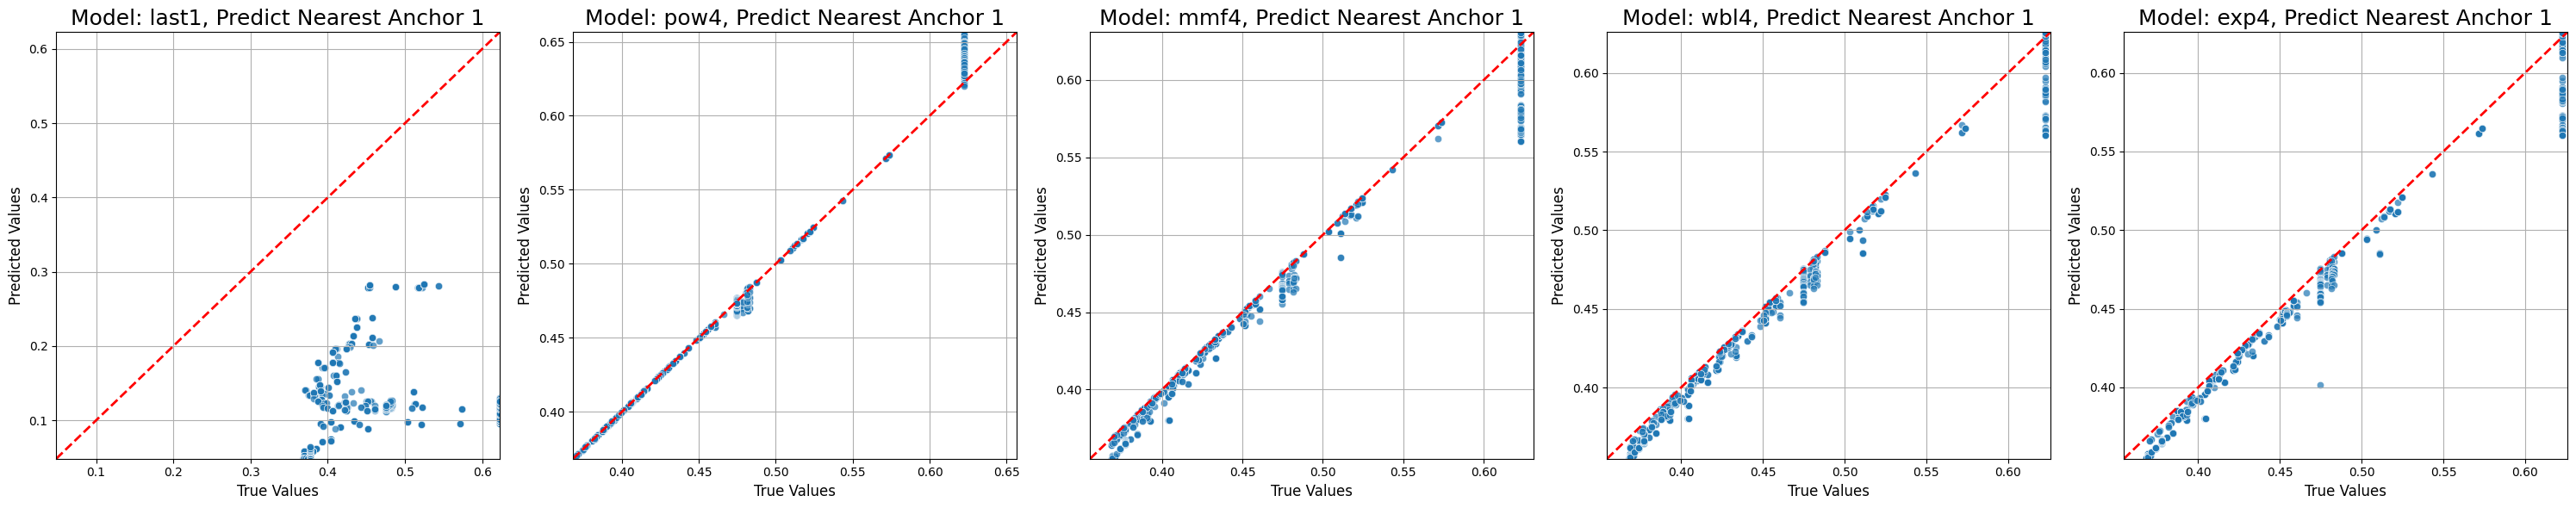

In [46]:
fig, axs = plt.subplots(num_anchor_pred, len(model_group), figsize=(6 * len(model_group), 6 * num_anchor_pred))
for i, model_name in enumerate(model_group):
    model_data = result_df[result_df['curve_model'] == model_name]
    ax = axs[i]

    scores = np.array([score[j] for score in model_data['scores']])
    predictions = np.array([pred[j] for pred in model_data['predictions']])

    # remove NaN 
    mask = ~np.isnan(scores) & ~np.isnan(predictions)
    scores = scores[mask]
    predictions = predictions[mask]

    # plot
    sns.scatterplot(x=scores, y=predictions, alpha=0.7, ax=ax)
    min_value = min(scores.min(), predictions.min())
    max_value = max(scores.max(), predictions.max())
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # y = x
    ax.plot([min_value, max_value], [min_value, max_value], 'r--', lw=2)

    ax.set_title(f'Model: {model_name}, Predict Nearest Anchor 1', fontsize = 18)
    ax.set_xlabel('True Values', fontsize = 12)
    ax.set_ylabel('Predicted Values', fontsize = 12)
    ax.grid(True)

plt.tight_layout()
plt.show()

predict the nearest 2 anchor

In [ ]:
num_anchor_pred = 2
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=num_anchor_pred)
result_df = pd.DataFrame(fitting_results)


In [53]:
print("Results:")
for model_name in model_group:
    model_data = result_df[result_df['curve_model'] == model_name]
    if len(model_data) > 0:
        avg_mse = model_data["mse"].mean()
        std_mse = model_data["mse"].std()
        success_rate = (fit_stats[model_name]["successful_fits"] / fit_stats[model_name]["total_fits"]) * 100
        print(f"Model: {model_name}")
        print(f"  Average MSE: {avg_mse}")
        print(f"  Std of MSE: {std_mse}")
        print(f"  Fitting rate: {success_rate:.2f}% with {fit_stats[model_name]['successful_fits']} successful fits in total {fit_stats[model_name]['total_fits']}")


Results:
Model: last1
  Average MSE: 0.0003161916712574699
  Std of MSE: 0.0003906015897750183
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4
  Average MSE: 0.0010454983595044353
  Std of MSE: 0.0028654301384552178
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4
  Average MSE: 0.0007787458229708886
  Std of MSE: 0.0009942396196606798
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4
  Average MSE: 0.0009140931928830859
  Std of MSE: 0.0010608234222747853
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4
  Average MSE: 0.0009300081820461523
  Std of MSE: 0.0010851624293987158
  Fitting rate: 100.00% with 1020 successful fits in total 1020


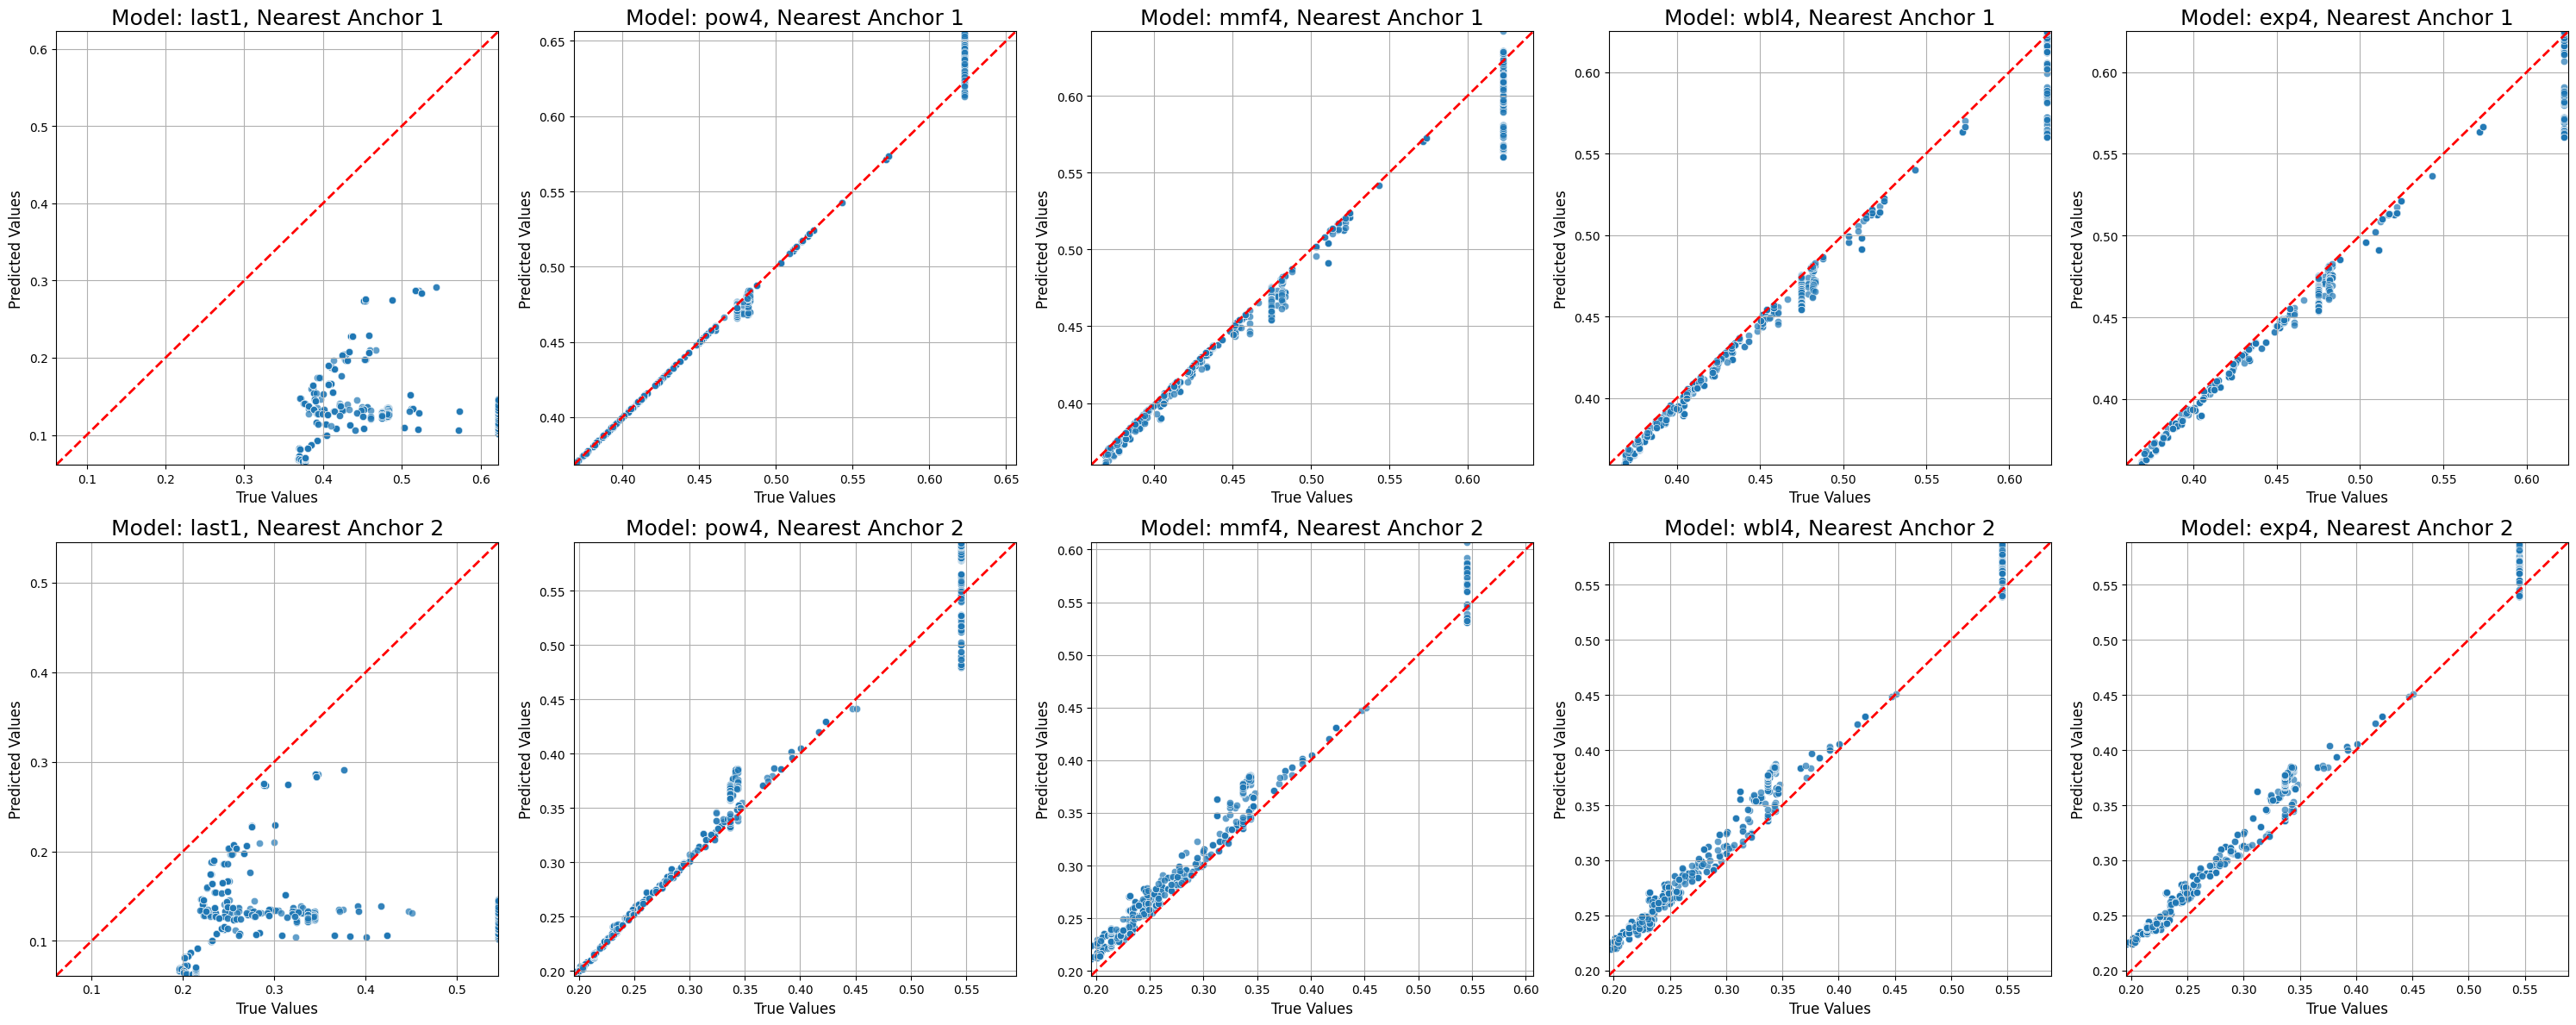

In [55]:
fig, axs = plt.subplots(num_anchor_pred, len(model_group), figsize=(6 * len(model_group), 6 * num_anchor_pred))
for i, model_name in enumerate(model_group):
    model_data = result_df[result_df['curve_model'] == model_name]
    for j in range(num_anchor_pred):
        ax = axs[j, i]
        scores = np.array([score[j] for score in model_data['scores']])
        predictions = np.array([pred[j] for pred in model_data['predictions']])
        mask = ~np.isnan(scores) & ~np.isnan(predictions)
        scores = scores[mask]
        predictions = predictions[mask]
        sns.scatterplot(x=scores, y=predictions, alpha=0.7, ax=ax)
        min_value = min(scores.min(), predictions.min())
        max_value = max(scores.max(), predictions.max())
        ax.set_xlim(min_value, max_value)
        ax.set_ylim(min_value, max_value)
        ax.plot([min_value, max_value], [min_value, max_value], 'r--', lw=2)
        ax.set_title(f'Model: {model_name}, Nearest Anchor {j+1}', fontsize = 18)
        ax.set_xlabel('True Values', fontsize = 12)
        ax.set_ylabel('Predicted Values', fontsize = 12)
        ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
num_anchor_pred = 3
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=num_anchor_pred)
result_df = pd.DataFrame(fitting_results)

In [57]:
print("Results:")
for model_name in model_group:
    model_data = result_df[result_df['curve_model'] == model_name]
    if len(model_data) > 0:
        avg_mse = model_data["mse"].mean()
        std_mse = model_data["mse"].std()
        success_rate = (fit_stats[model_name]["successful_fits"] / fit_stats[model_name]["total_fits"]) * 100
        print(f"Model: {model_name}")
        print(f"  Average MSE: {avg_mse}")
        print(f"  Std of MSE: {std_mse}")
        print(f"  Fitting rate: {success_rate:.2f}% with {fit_stats[model_name]['successful_fits']} successful fits in total {fit_stats[model_name]['total_fits']}")


Results:
Model: last1
  Average MSE: 0.0006246020961278763
  Std of MSE: 0.0007248739125245276
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4
  Average MSE: 0.0015571674905475014
  Std of MSE: 0.00367988136554481
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4
  Average MSE: 0.0010967416665960373
  Std of MSE: 0.001831419785379405
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4
  Average MSE: 0.001130301859639771
  Std of MSE: 0.001265257946469047
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4
  Average MSE: 0.0011327987021858717
  Std of MSE: 0.001290441553689499
  Fitting rate: 100.00% with 1020 successful fits in total 1020


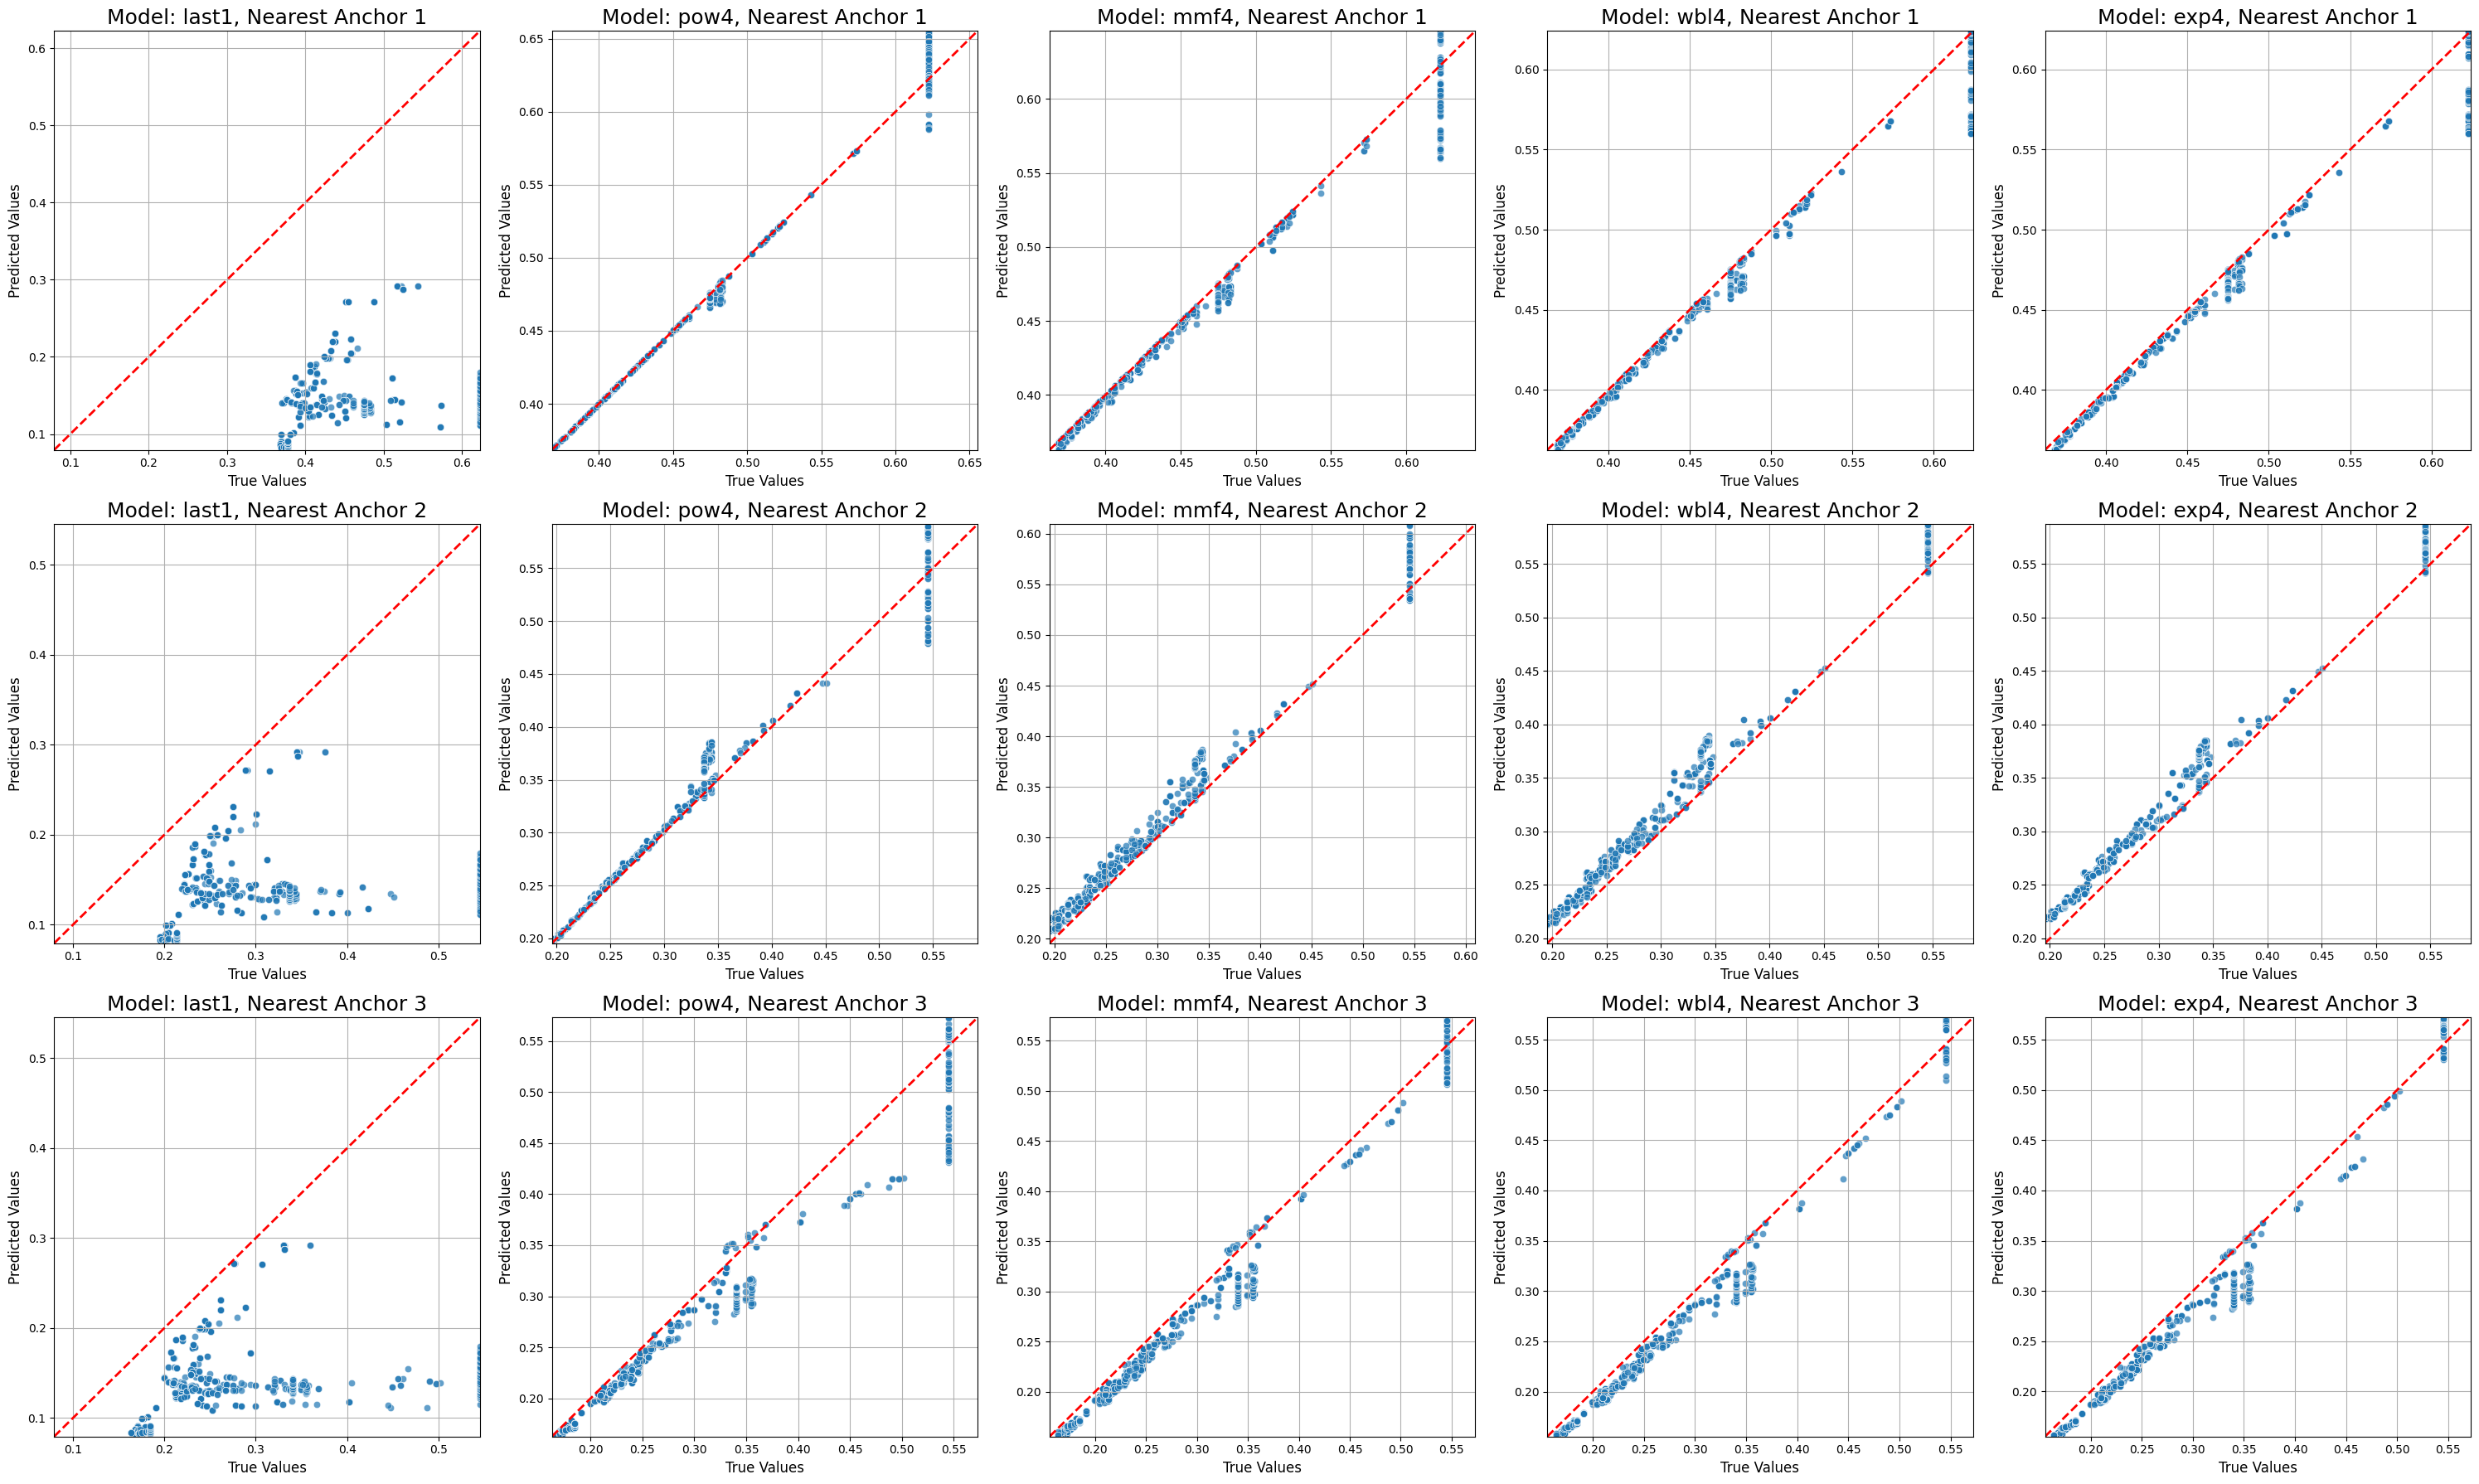

In [58]:
fig, axs = plt.subplots(num_anchor_pred, len(model_group), figsize=(6 * len(model_group), 6 * num_anchor_pred))
for i, model_name in enumerate(model_group):
    model_data = result_df[result_df['curve_model'] == model_name]
    for j in range(num_anchor_pred):
        ax = axs[j, i]
        scores = np.array([score[j] for score in model_data['scores']])
        predictions = np.array([pred[j] for pred in model_data['predictions']])
        mask = ~np.isnan(scores) & ~np.isnan(predictions)
        scores = scores[mask]
        predictions = predictions[mask]
        sns.scatterplot(x=scores, y=predictions, alpha=0.7, ax=ax)
        min_value = min(scores.min(), predictions.min())
        max_value = max(scores.max(), predictions.max())
        ax.set_xlim(min_value, max_value)
        ax.set_ylim(min_value, max_value)
        ax.plot([min_value, max_value], [min_value, max_value], 'r--', lw=2)
        ax.set_title(f'Model: {model_name}, Nearest Anchor {j+1}', fontsize = 18)
        ax.set_xlabel('True Values', fontsize = 12)
        ax.set_ylabel('Predicted Values', fontsize = 12)
        ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
num_anchor_pred = 4
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=num_anchor_pred)
result_df = pd.DataFrame(fitting_results)


In [60]:
print("Results:")
for model_name in model_group:
    model_data = result_df[result_df['curve_model'] == model_name]
    if len(model_data) > 0:
        avg_mse = model_data["mse"].mean()
        std_mse = model_data["mse"].std()
        success_rate = (fit_stats[model_name]["successful_fits"] / fit_stats[model_name]["total_fits"]) * 100
        print(f"Model: {model_name}")
        print(f"  Average MSE: {avg_mse}")
        print(f"  Std of MSE: {std_mse}")
        print(f"  Fitting rate: {success_rate:.2f}% with {fit_stats[model_name]['successful_fits']} successful fits in total {fit_stats[model_name]['total_fits']}")


Results:
Model: last1
  Average MSE: 0.001152624308828577
  Std of MSE: 0.001224913681974894
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4
  Average MSE: 0.002304983987741543
  Std of MSE: 0.004627589100843938
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4
  Average MSE: 0.0013491641853470271
  Std of MSE: 0.0021432270682152747
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4
  Average MSE: 0.0015411749857545684
  Std of MSE: 0.0021136818830138323
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4
  Average MSE: 0.0015227145529846308
  Std of MSE: 0.0022780047261419167
  Fitting rate: 100.00% with 1020 successful fits in total 1020


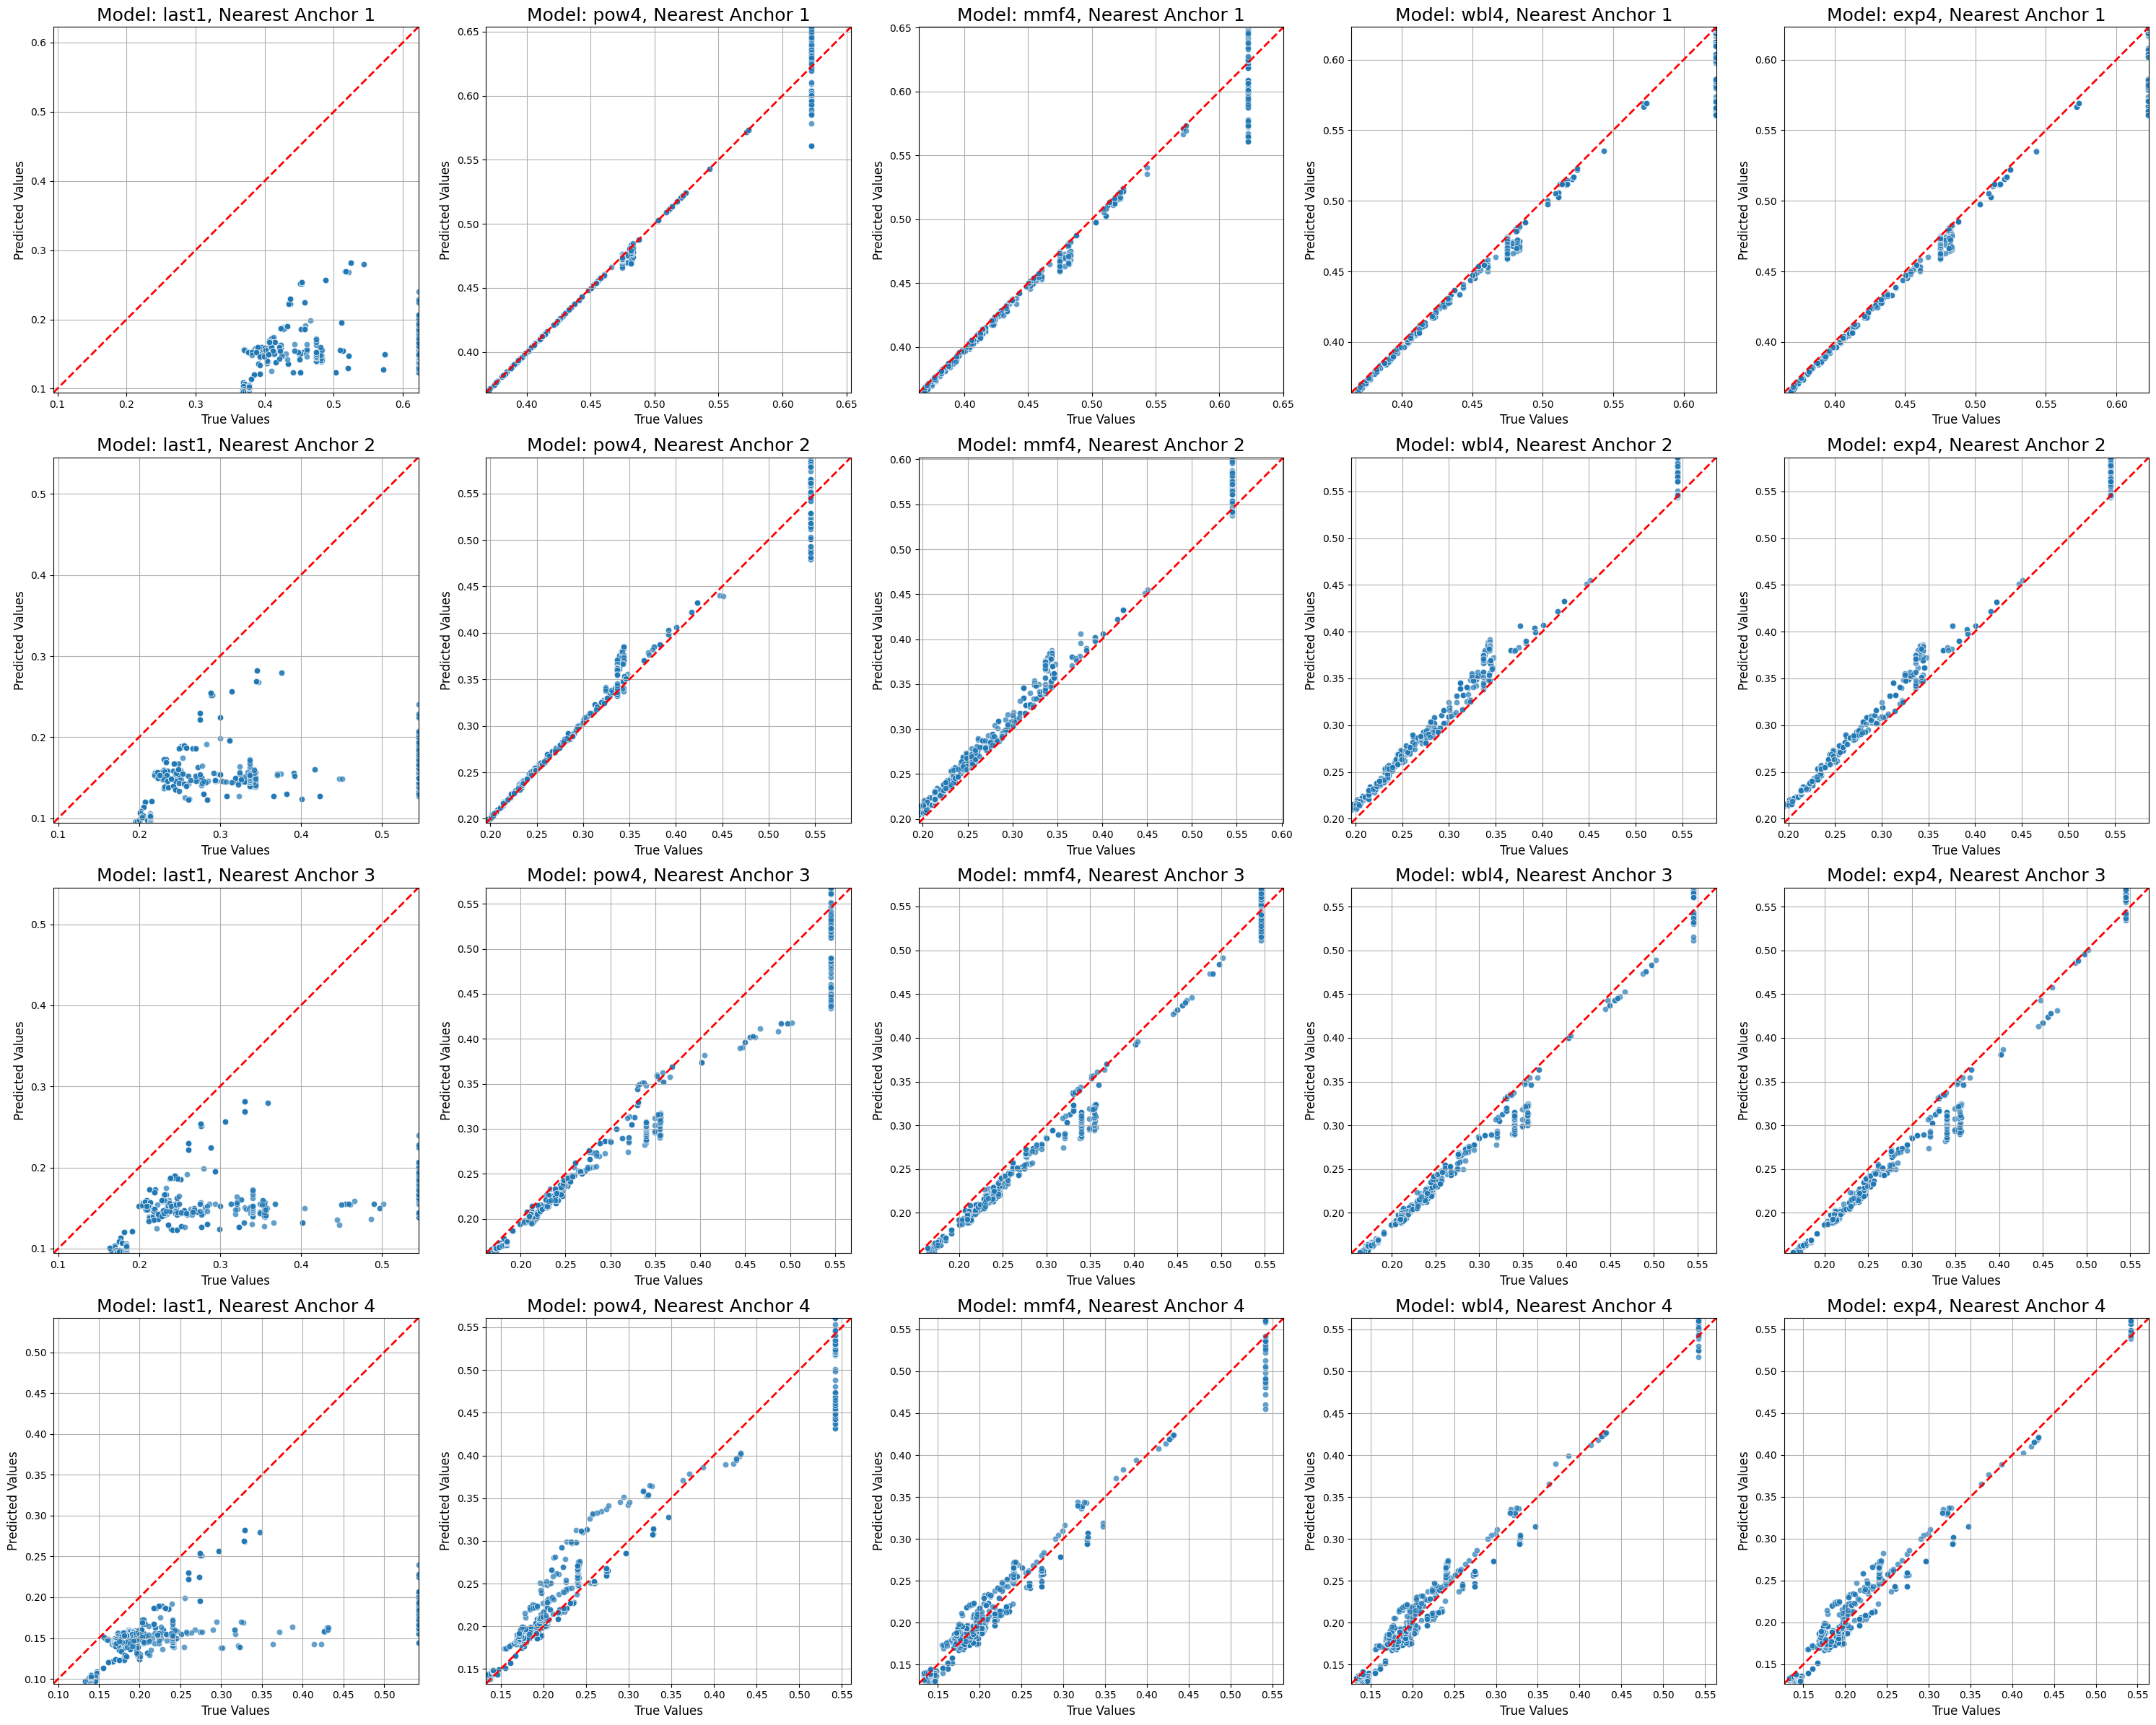

In [61]:
fig, axs = plt.subplots(num_anchor_pred, len(model_group), figsize=(6 * len(model_group), 6 * num_anchor_pred))
for i, model_name in enumerate(model_group):
    model_data = result_df[result_df['curve_model'] == model_name]
    for j in range(num_anchor_pred):
        ax = axs[j, i]
        scores = np.array([score[j] for score in model_data['scores']])
        predictions = np.array([pred[j] for pred in model_data['predictions']])
        mask = ~np.isnan(scores) & ~np.isnan(predictions)
        scores = scores[mask]
        predictions = predictions[mask]
        sns.scatterplot(x=scores, y=predictions, alpha=0.7, ax=ax)
        min_value = min(scores.min(), predictions.min())
        max_value = max(scores.max(), predictions.max())
        ax.set_xlim(min_value, max_value)
        ax.set_ylim(min_value, max_value)
        ax.plot([min_value, max_value], [min_value, max_value], 'r--', lw=2)
        ax.set_title(f'Model: {model_name}, Nearest Anchor {j+1}', fontsize = 18)
        ax.set_xlabel('True Values', fontsize = 12)
        ax.set_ylabel('Predicted Values', fontsize = 12)
        ax.grid(True)
plt.tight_layout()
plt.show()

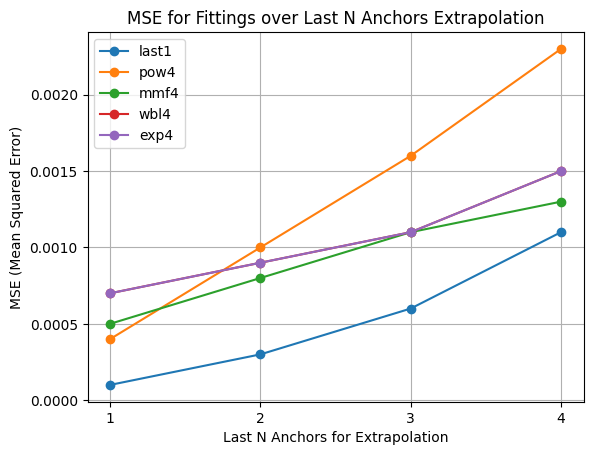

In [65]:
N_values = [1, 2, 3, 4]

mse_last1 = [0.0001, 0.0003, 0.0006, 0.0011]
mse_pow4 = [0.0004, 0.0010, 0.0016, 0.0023]
mse_mmf4 = [0.0005, 0.0008, 0.0011, 0.0013]
mse_wbl4 = [0.0007, 0.0009, 0.0011, 0.0015]
mse_exp4 = [0.0007, 0.0009, 0.0011, 0.0015]


plt.figure()
plt.plot(N_values, mse_last1, marker='o', label='last1')
plt.plot(N_values, mse_pow4, marker='o', label='pow4')
plt.plot(N_values, mse_mmf4, marker='o', label='mmf4')
plt.plot(N_values, mse_wbl4, marker='o', label='wbl4')
plt.plot(N_values, mse_exp4, marker='o', label='exp4')
plt.xticks(N_values)
plt.xlabel('Last N Anchors for Extrapolation')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('MSE for Fittings over Last N Anchors Extrapolation')

plt.legend()
plt.grid(True)
plt.show()
